# Financial Analysis Project
### Group 3: Margarida Pereira, Sanjo Joy, Maine Isasi, Isaac Chaljub, Pablo Gallegos

## 1. Selecting a Financial Time Series Dataset

### Individual Company Stock Selected: Louis Vuitton, ticker "LVMHF".
#### Source: Yahoo Finance (yfinance library).
#### Period: Years 2015 - 2024
#### Goal: Given that Louis Vuitton is a luxury brand, it is expected to exhibit higher risk (volatility) compared to companies that produce essential goods. To assess this, we will conduct a comparative analysis through variance modeling using time series models.

In [1]:
#import yfinance as yf



#louis_vuitton = yf.download("LVMHF", start="2015-01-01", end="2024-12-31")

#lv = louis_vuitton['Close']


In [2]:
#lv = louis_vuitton.copy()
#lv = lv.reset_index(drop=False)
#lv.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
#lv= lv.set_index('Date')

#lv = lv['Close']

#lv.to_csv('LVMHF_2015_2024.csv')

In [3]:
import pandas as pd

lv = pd.read_csv('LVMHF_2015_2024.csv', parse_dates=True, index_col=0)

lv.head()

,Close
Date,
2015-01-02,134.303635
2015-01-05,129.202744
2015-01-06,126.588646
2015-01-07,125.884178
2015-01-08,129.363998


## 2. Exploratory Data Analysis (EDA)


### Plot the raw time series and discuss volatility clustering.

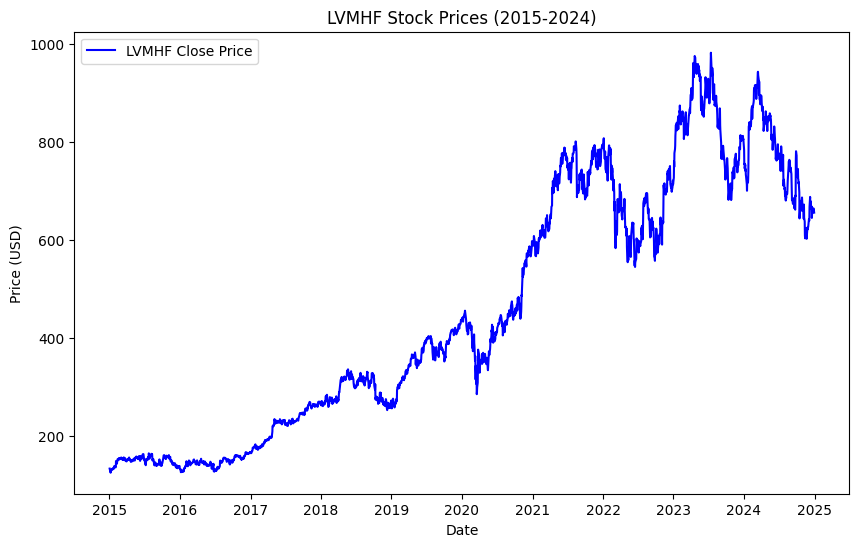

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lv.index, lv['Close'], label='LVMHF Close Price', color='blue')
plt.title('LVMHF Stock Prices (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


##### The raw time series visually shows volatility clustering as periods of high variance are followed by more variance, and the same for periods of low variance.

### Compute and analyze log-returns of the time series.

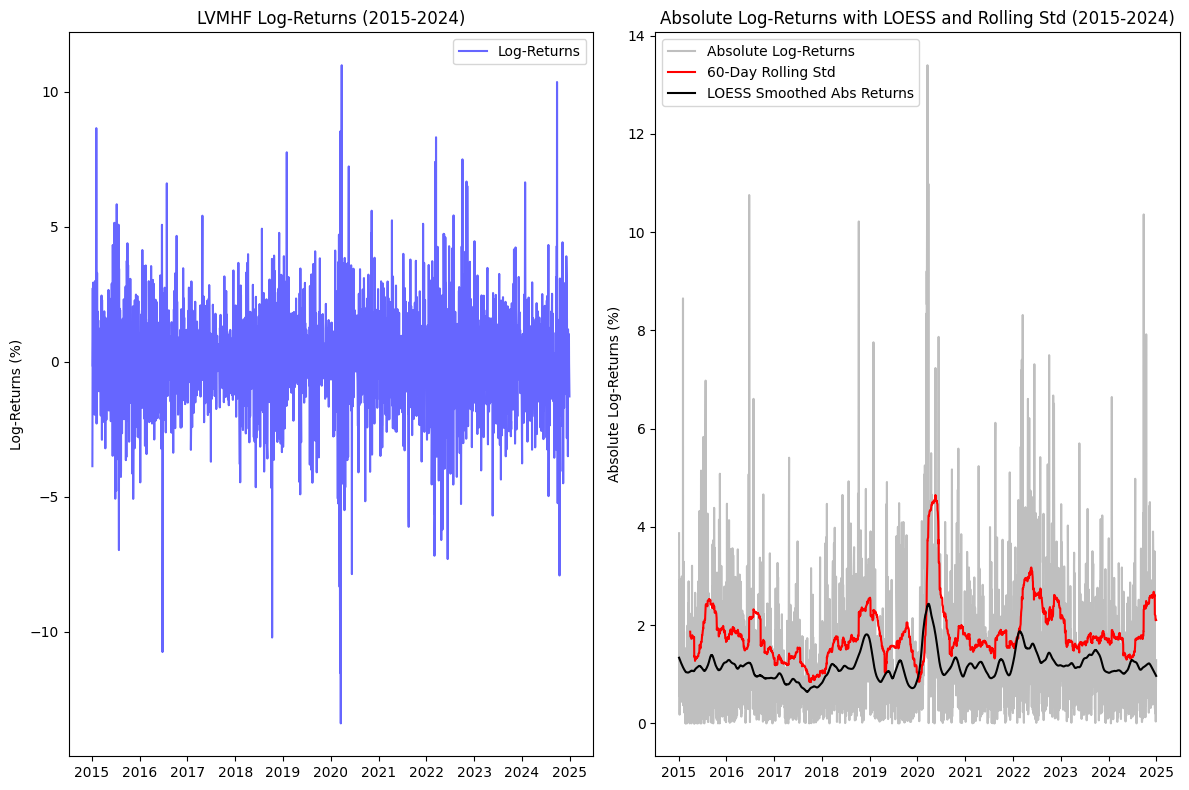

In [5]:
import numpy as np
import statsmodels.api as sm


# Compute percentage log-return
lv['Log_Return'] = np.log(lv['Close'] / lv['Close'].shift(1))*100
lv.dropna(inplace=True)

# Compute absolute log-returns
lv['Abs_Log_Return'] = np.abs(lv['Log_Return'])

# Compute rolling 60-day standard deviation
lv['Rolling_Std'] = lv['Log_Return'].rolling(window=60).std()

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(lv['Abs_Log_Return'], lv.index, frac=0.03)


# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

# Plot log-returns
top_ax = axes[0]
top_ax.plot(lv.index, lv['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
top_ax.set_ylabel("Log-Returns (%)")
top_ax.set_title("LVMHF Log-Returns (2015-2024)")
top_ax.legend()

# Plot absolute log-returns with LOESS and rolling std
bottom_ax = axes[1]
bottom_ax.plot(lv.index, lv['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
bottom_ax.plot(lv.index, lv['Rolling_Std'], color='red', label='60-Day Rolling Std')
bottom_ax.plot(lv.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
bottom_ax.set_ylabel("Absolute Log-Returns (%)")
bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2015-2024)")
bottom_ax.legend()

plt.tight_layout()
plt.show()

##### Log-Returns fluctuate around zero.<br /> Absolute Log-Returns show the (high) magnitude of price changes without considering the direction.<br /> Both 60-day Rolling Std Dev and LOESS Smoothed Abs Returns help to recognize periods of high or low volatility.

### Compute summary statistics and analyze stationarity of log-returns.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Summary statistics
print("Log-Returns Summary Statistics:")
print(lv['Log_Return'].describe())
print(f"Skewness: {lv['Log_Return'].skew():.4f}")
print(f"Kurtosis: {lv['Log_Return'].kurtosis():.4f}")

# Augmented Dickey-Fuller test for stationarity
adf_result = adfuller(lv['Log_Return'])
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

Log-Returns Summary Statistics:
count    2514.000000
mean        0.063089
std         1.929046
min       -13.399838
25%        -0.983145
50%         0.085152
75%         1.112090
max        10.983622
Name: Log_Return, dtype: float64
Skewness: -0.2190
Kurtosis: 4.2939

ADF Test Results:
ADF Statistic: -17.5593
p-value: 0.0000


##### Mean is 0.063, close to zero. <br /> Negative skewness indicates asymmetry in returns.<br /> Kurtosis 4.259 (higher than 3) suggest fatter tails than normal distribution (more likelihood of extreme events).<br /> ADF Test's p-value lower than 0.05 suggests log-returns stationarity (prerequisite for volatility modeling).

### Check autocorrelation and partial autocorrelation functions of log-returns.

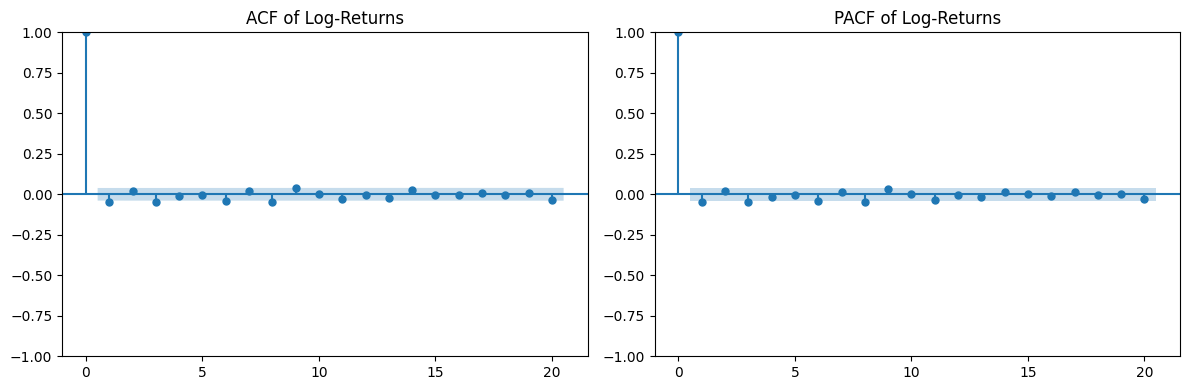

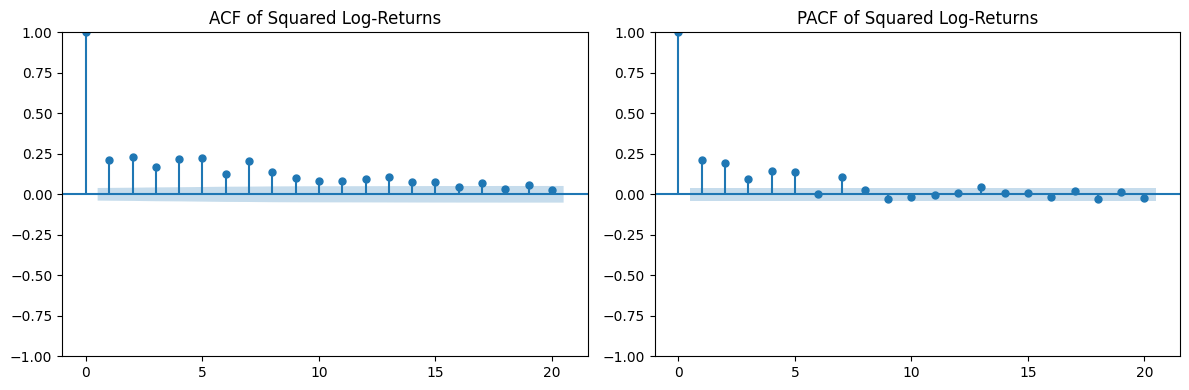

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF for log-returns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(lv['Log_Return'], lags=20, ax=plt.gca())
plt.title('ACF of Log-Returns')
plt.subplot(1, 2, 2)
plot_pacf(lv['Log_Return'], lags=20, ax=plt.gca())
plt.title('PACF of Log-Returns')
plt.tight_layout()
plt.show()

# ACF and PACF for squared log-returns
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_acf(lv['Log_Return']**2, lags=20, ax=plt.gca())
plt.title('ACF of Squared Log-Returns')
plt.subplot(1, 2, 2)
plot_pacf(lv['Log_Return']**2, lags=20, ax=plt.gca())
plt.title('PACF of Squared Log-Returns')
plt.tight_layout()
plt.show()

##### ACF and PACF for log-returns: no autocorrelation is expected.<br /> ACF and PACF for squared log-returns: significant autocorrelation indicates volatility clustering, justifying the use of ARCH/GARCH models.


## 3. Volatility Modeling

### Fit various models (e.g., ARCH, GARCH, GJR-GARCH, EGARCH) to the log-returns.

In [8]:
from arch import arch_model

# Fit ARCH(1) model
arch_model = arch_model(lv['Log_Return'], vol='ARCH', p=1, mean='AR', rescale=True)
arch_fit = arch_model.fit(disp='off')
print(arch_fit.summary())

                           AR - ARCH Model Results                            
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5136.42
Distribution:                  Normal   AIC:                           10278.8
Method:            Maximum Likelihood   BIC:                           10296.3
                                        No. Observations:                 2514
Date:                Tue, Mar 18 2025   Df Residuals:                     2513
Time:                        22:38:58   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.0698  3.550e-02      1.965  4.944e-02 [1.716e-0

In [9]:
from arch import arch_model

# Fit GARCH(1,1)
garch_model = arch_model(lv['Log_Return'], mean = 'AR', vol='Garch', p=1, o=0, q=1, dist='t')
garch_fit = garch_model.fit(disp='off')
print(garch_fit.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4983.81
Distribution:      Standardized Student's t   AIC:                           9977.61
Method:                  Maximum Likelihood   BIC:                           10006.8
                                              No. Observations:                 2514
Date:                      Tue, Mar 18 2025   Df Residuals:                     2513
Time:                              22:38:58   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const     

In [17]:
# Fit GJR-GARCH(1,1,1)
GJR_garch_model = arch_model(lv['Log_Return'], vol='Garch', p=1, q=1, o=1, mean='AR', rescale=True)
GJR_garch_fit = GJR_garch_model.fit(disp='off')
print(GJR_garch_fit.summary())

                         AR - GJR-GARCH Model Results                         
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -5033.47
Distribution:                  Normal   AIC:                           10076.9
Method:            Maximum Likelihood   BIC:                           10106.1
                                        No. Observations:                 2514
Date:                Tue, Mar 18 2025   Df Residuals:                     2513
Time:                        22:40:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.0680  3.331e-02      2.041  4.128e-02 [2.690e-0

In [11]:
# Fit EGARCH(1,1)
egarch_model = arch_model(lv['Log_Return'], vol='EGarch', p=1, q=1, mean='AR', rescale=True)
egarch_fit = egarch_model.fit(disp='off')
print(egarch_fit.summary())

                          AR - EGARCH Model Results                           
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5041.65
Distribution:                  Normal   AIC:                           10091.3
Method:            Maximum Likelihood   BIC:                           10114.6
                                        No. Observations:                 2514
Date:                Tue, Mar 18 2025   Df Residuals:                     2513
Time:                        22:38:58   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.0963  3.281e-02      2.934  3.349e-03 [3.195e-0

### Justify model selection using statistical criteria (AIC, BIC, likelihood ratio tests).

In [21]:
# Fit multiple models
models = {
    'ARCH(1)': arch_model(lv['Log_Return'], vol='ARCH', p=1, mean='AR', rescale=True).fit(disp='off'),
    'ARCH(2)': arch_model(lv['Log_Return'], vol='ARCH', p=2, mean='AR', rescale=True).fit(disp='off'),
    'GARCH(1,1)': arch_model(lv['Log_Return'], vol='Garch', p=1, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GARCH(2,1)': arch_model(lv['Log_Return'], vol='Garch', p=2, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GARCH(1,2)': arch_model(lv['Log_Return'], vol='Garch', p=1, q=2, mean='AR', rescale=True).fit(disp='off'),
    'GARCH(2,2)': arch_model(lv['Log_Return'], vol='Garch', p=2, q=2, mean='AR', rescale=True).fit(disp='off'),
    'GJR-GARCH(1,1,1)': arch_model(lv['Log_Return'], vol='Garch', p=1, o=1, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GJR-GARCH(2,1,1)': arch_model(lv['Log_Return'], vol='Garch', p=2, o=1, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GJR-GARCH(3,1,1)': arch_model(lv['Log_Return'], vol='Garch', p=3, o=1, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GJR-GARCH(1,2,1)': arch_model(lv['Log_Return'], vol='Garch', p=1, o=2, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GJR-GARCH(1,3,1)': arch_model(lv['Log_Return'], vol='Garch', p=1, o=3, q=1, mean='AR', rescale=True).fit(disp='off'),
    'GJR-GARCH(2,2,1)': arch_model(lv['Log_Return'], vol='Garch', p=2, o=2, q=1, mean='AR', rescale=True).fit(disp='off'),
    'EGARCH(1,1)': arch_model(lv['Log_Return'], vol='EGarch', p=1, q=1, mean='AR', rescale=True).fit(disp='off'),
    'EGARCH(2,1)': arch_model(lv['Log_Return'], vol='EGarch', p=2, q=1, mean='AR', rescale=True).fit(disp='off')
}

# Compare AIC and BIC
for name, fit in models.items():
    print(f"{name}: AIC = {fit.aic:.4f}, BIC = {fit.bic:.4f}")


ARCH(1): AIC = 10278.8441, BIC = 10296.3330
ARCH(2): AIC = 10221.5815, BIC = 10244.9000
GARCH(1,1): AIC = 10094.6686, BIC = 10117.9871
GARCH(2,1): AIC = 10096.6686, BIC = 10125.8167
GARCH(1,2): AIC = 10096.3364, BIC = 10125.4846
GARCH(2,2): AIC = 10098.1066, BIC = 10133.0844
GJR-GARCH(1,1,1): AIC = 10076.9373, BIC = 10106.0855
GJR-GARCH(2,1,1): AIC = 10078.9373, BIC = 10113.9151
GJR-GARCH(3,1,1): AIC = 10080.9373, BIC = 10121.7447
GJR-GARCH(1,2,1): AIC = 10078.9271, BIC = 10113.9048
GJR-GARCH(1,3,1): AIC = 10080.9271, BIC = 10121.7345
GJR-GARCH(2,2,1): AIC = 10080.9271, BIC = 10121.7345
EGARCH(1,1): AIC = 10091.3028, BIC = 10114.6214
EGARCH(2,1): AIC = 10092.1482, BIC = 10121.2963


##### GJR-GARCH(1,1,1) has the lowest AIC and BIC

### Evaluate model diagnostics and residual behavior.

Standardized Residuals Summary Statistics:
  Mean:      -0.0065
  Std Dev:   1.0009
  Skewness:  -0.1076
  Kurtosis:  1.9803

Ljung-Box test for Standardized Residuals (lag=10):
      lb_stat  lb_pvalue
10  10.311937   0.413565 

Ljung-Box test for Squared Standardized Residuals (lag=10):
     lb_stat  lb_pvalue
10  3.406654   0.970173 



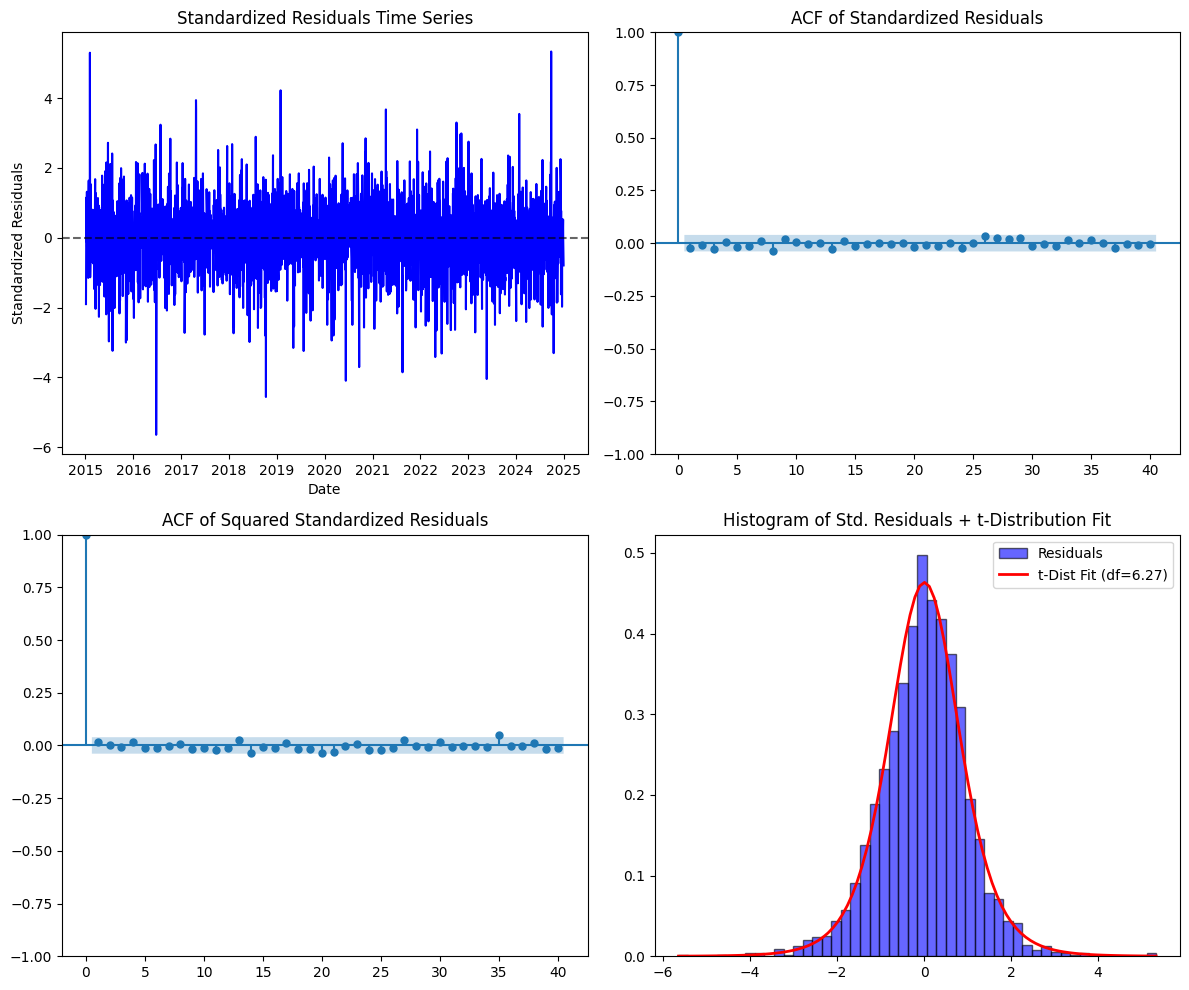

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import t, probplot

import numpy as np

# -------------------------
# 1. Compute standardized residuals of GJR-GARCH(1,1,1)
# -------------------------
std_residuals = GJR_garch_fit.resid / GJR_garch_fit.conditional_volatility
std_residuals = std_residuals.dropna()

# -------------------------
# 2. Calculate key summary statistics
# -------------------------
mean_resid = std_residuals.mean()
std_resid = std_residuals.std()
skew_resid = std_residuals.skew()
kurt_resid = std_residuals.kurtosis()

print("Standardized Residuals Summary Statistics:")
print(f"  Mean:      {mean_resid:.4f}")
print(f"  Std Dev:   {std_resid:.4f}")
print(f"  Skewness:  {skew_resid:.4f}")
print(f"  Kurtosis:  {kurt_resid:.4f}\n")

# -------------------------
# 3. Ljung-Box tests for autocorrelation
#    (Both raw and squared residuals)
# -------------------------
# Test at multiple lags if desired
lb_test_raw = acorr_ljungbox(std_residuals, lags=[10], return_df=True)
lb_test_sq  = acorr_ljungbox(std_residuals**2, lags=[10], return_df=True)

print("Ljung-Box test for Standardized Residuals (lag=10):")
print(lb_test_raw, "\n")
print("Ljung-Box test for Squared Standardized Residuals (lag=10):")
print(lb_test_sq, "\n")

# -------------------------
# 4. Plot residual diagnostics in a 2x2 grid
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 4.1 Standardized residual time series
sns.lineplot(x=std_residuals.index, y=std_residuals, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Standardized Residuals Time Series")
axes[0, 0].set_ylabel("Standardized Residuals")
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.6)

# 4.2 ACF of standardized residuals
plot_acf(std_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title("ACF of Standardized Residuals")

# 4.3 ACF of squared standardized residuals
plot_acf(std_residuals**2, ax=axes[1, 0], lags=40)
axes[1, 0].set_title("ACF of Squared Standardized Residuals")

# 4.4 QQ-plot with estimated t-distribution (histogram + fitted t-dist)
df_t, loc_t, scale_t = t.fit(std_residuals)
x = np.linspace(std_residuals.min(), std_residuals.max(), 100)
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

axes[1, 1].hist(std_residuals, bins=50, density=True, alpha=0.6, color='blue',
                edgecolor='black', label="Residuals")
axes[1, 1].plot(x, pdf_t, color='red', lw=2, 
                label=f't-Dist Fit (df={df_t:.2f})')
axes[1, 1].set_title("Histogram of Std. Residuals + t-Distribution Fit")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4. Risk Modeling and Interpretation

### Compute and interpret Value at Risk (VaR) at different confidence levels using log-returns.

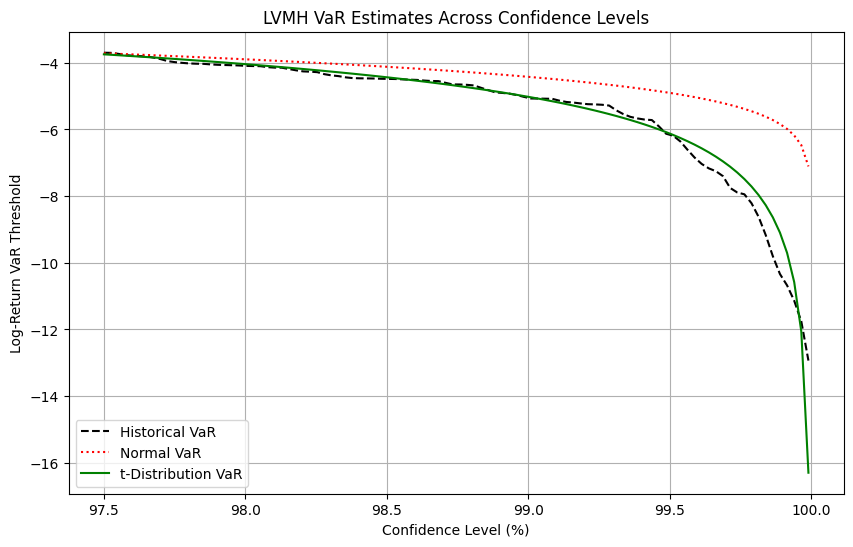

In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t

returns = lv['Log_Return'].dropna()
confidence_levels = np.linspace(0.975, 0.9999, 100)

VaR_hist = [
    np.percentile(returns, (1 - alpha) * 100)
    for alpha in confidence_levels
]

# 3.2 Normal VaR (assuming returns ~ Normal(mean, std))
mu, sigma = np.mean(returns), np.std(returns)
VaR_norm = [
    norm.ppf(1 - alpha, loc=mu, scale=sigma)
    for alpha in confidence_levels
]

# 3.3 t-Distribution VaR (fit t-distribution to returns)
df_t, loc_t, scale_t = t.fit(returns)
VaR_t = [
    loc_t + scale_t * t.ppf(1 - alpha, df_t)
    for alpha in confidence_levels
]

# -------------------------
# 4. Plot VaR estimates as a function of confidence level
# -------------------------
plt.figure(figsize=(10, 6))

plt.plot(confidence_levels * 100, VaR_hist,
         label='Historical VaR', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, VaR_norm,
         label='Normal VaR', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, VaR_t,
         label='t-Distribution VaR', linestyle='solid', color='green')

plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Return VaR Threshold")
plt.title("LVMH VaR Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

##### 99.5% t-Distribution VaR estimates there is a 0.5% chance of losing more than 6%.
##### (We used the t-Distribution VaR for interpretation as it follows more closely the log-returns true distribution than Normal VaR. Also it is very similar to Historical/empiric VaR.)


### Estimate Expected Shortfall (Conditional VaR) and assess tail risk.


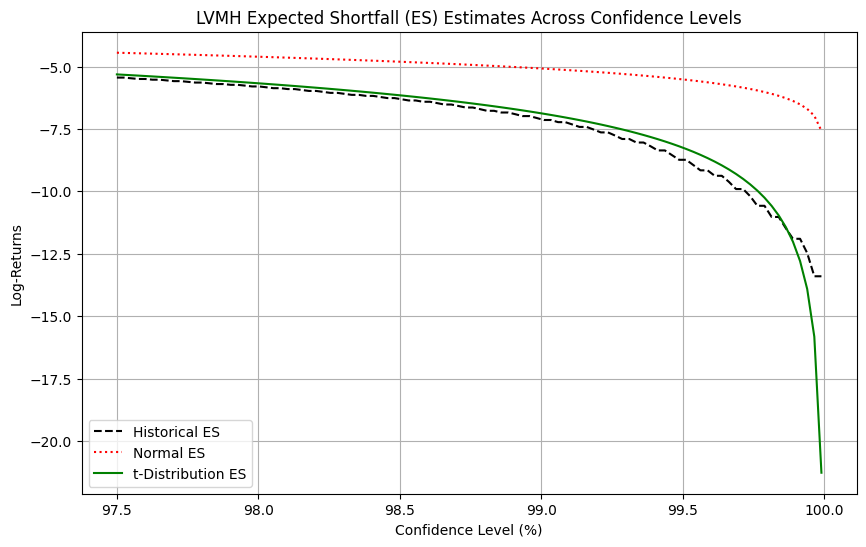

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# -------------------------
# 1. Prepare the data
# -------------------------
# Example: Suppose you have a DataFrame `btc` with 'Log_Return' column.
# Replace this with your actual log-returns series variable.
returns = lv['Log_Return'].dropna()

# Fit a t-distribution to your returns (for the t-based ES)
df_t, loc_t, scale_t = t.fit(returns)

# Mean and std for Normal approach
mean_return = returns.mean()
std_return = returns.std()

# -------------------------
# 2. Define confidence levels
# -------------------------
confidence_levels = np.linspace(0.975, 0.9999, 100)

# -------------------------
# 3. Compute Historical VaR for each confidence level
#    (We need this to calculate Historical ES)
# -------------------------
VaR_hist = [
    np.percentile(returns, (1 - alpha) * 100)
    for alpha in confidence_levels
]

# -------------------------
# 4. Compute Expected Shortfall (ES) using the proper formulas
# -------------------------
# 4.1 Normal ES
# ES_normal = μ - σ * (φ(Φ^{-1}(α)) / (1 - α))
phi_norm = norm.pdf(norm.ppf(confidence_levels))
ES_norm = mean_return - std_return * (phi_norm / (1 - confidence_levels))

# 4.2 t-Distribution ES
# ES_t = loc_t - scale_t * [ (f(t_α) / (1 - α)) * ((ν + t_α^2) / (ν - 1)) ]
t_alpha = t.ppf(confidence_levels, df_t)
t_pdf_alpha = t.pdf(t_alpha, df_t)
ES_t = loc_t - scale_t * (
    (t_pdf_alpha / (1 - confidence_levels)) * ((df_t + t_alpha**2) / (df_t - 1))
)

# 4.3 Historical ES
# ES_hist(α) = Average of returns <= VaR_hist(α)
ES_hist = [
    returns[returns <= VaR_hist[i]].mean()
    for i in range(len(confidence_levels))
]

# -------------------------
# 5. Plot Expected Shortfall (ES) estimates as a function of confidence level
# -------------------------
plt.figure(figsize=(10, 6))

plt.plot(confidence_levels * 100, ES_hist,
         label='Historical ES', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, ES_norm,
         label='Normal ES', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, ES_t,
         label='t-Distribution ES', linestyle='solid', color='green')

plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns")
plt.title("LVMH Expected Shortfall (ES) Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()


### Discuss financial implications of risk estimates.

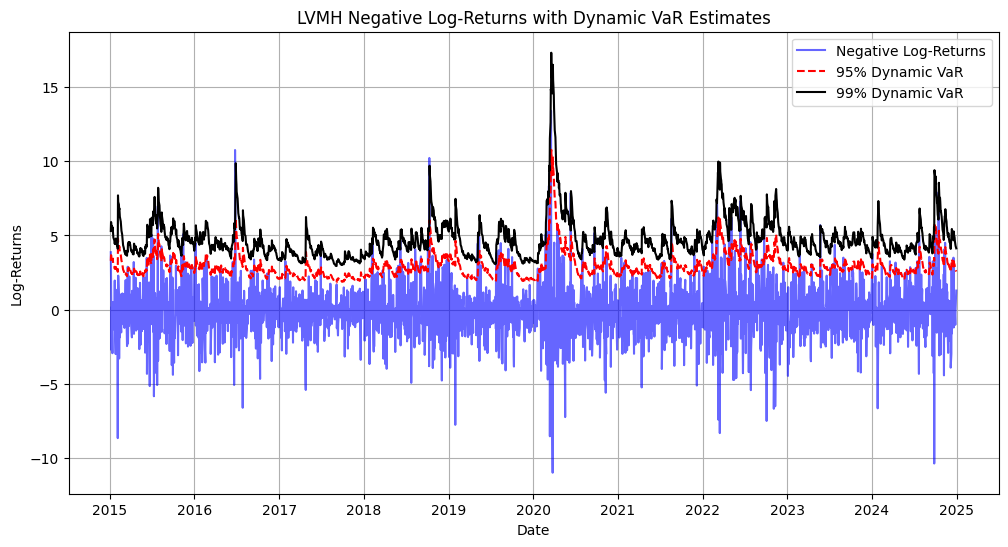

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# -------------------------
# 1. Extract conditional volatility and standardized residuals
# -------------------------
std_residuals = garch_fit.resid / garch_fit.conditional_volatility
std_residuals = std_residuals.dropna()
cond_volatility = garch_fit.conditional_volatility.dropna()

# -------------------------
# 2. Fit t-distribution to standardized residuals
# -------------------------
df_t, loc_t, scale_t = t.fit(std_residuals)

# -------------------------
# 3. Compute dynamic VaR at 95% and 99%
#    Using t-distribution quantiles scaled by conditional volatility
# -------------------------
VaR_95 = -scale_t * t.ppf(0.05, df_t) * cond_volatility
VaR_99 = -scale_t * t.ppf(0.01, df_t) * cond_volatility

# -------------------------
# 4. Plot negative log-returns with dynamic VaR
# -------------------------
plt.figure(figsize=(12, 6))

# Note: 'lv' is assumed to be your DataFrame with a 'Log_Return' column
plt.plot(-lv['Log_Return'], label="Negative Log-Returns", color='blue', alpha=0.6)
plt.plot(VaR_95, label="95% Dynamic VaR", linestyle='dashed', color='red')
plt.plot(VaR_99, label="99% Dynamic VaR", linestyle='solid', color='black')

plt.xlabel("Date")
plt.ylabel("Log-Returns")
plt.title("LVMH Negative Log-Returns with Dynamic VaR Estimates")
plt.legend()
plt.grid()
plt.show()
